In [42]:
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


## We are going to make a dataset using sklearn.datasets of circles.



In [43]:
n_samples=1000
X,y=make_circles(n_samples,noise=0.03,random_state=42)
len(X),len(y)


(1000, 1000)

In [44]:
print(f"First five samples of X:\n {X[:5]}")
print(f"First five samples of y:\n{y[:5]}")


First five samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five samples of y:
[1 1 1 1 0]


# convert it to Dataframe

In [45]:
circles=pd.DataFrame({"X1":X[:,0],
                      "X2":X[:,1],
                      "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


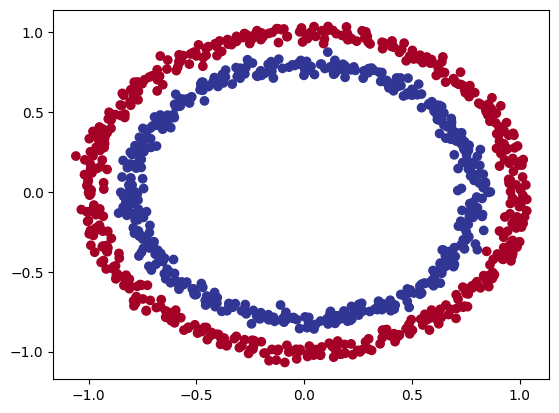

In [46]:
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu);

# check input and outputshapes

In [47]:
# convert the data into tensor
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)
type(X),X.dtype,y.dtype

(torch.Tensor, torch.float32, torch.float32)

# Device Agnostic Code


In [48]:
# Building the model
device='cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

In [49]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_test,y_train,y_test=X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

# ***The below is the more basic way of defining a network and its hard to write this code and there is one more way to create the model using the `nn.Sequential()`***

# *The Naive method or the tough one*
```
class CircleModelV0(nn.Module):
   def __init__(self):
         super().__init__()
         self.layer_1=nn.Linear(in_features=2,out_features=5)
         self.layer_2=nn.Linear(in_features=5,out_features=1)

   def forward(self,x):
         return self.layer_2(self.layer_1(x))

 model_0=CircleModelV0().to(device)
 model_0
```

# ***The easy one or the fast one***
```
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1),
).to(device)
model_0
```

In [50]:
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=10),
    nn.Linear(in_features=10,out_features=5),
    nn.Linear(in_features=5,out_features=1),
)

In [51]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model_0.parameters(),lr=0.01)
epochs=1000
for epoch in range(epochs):
    model_0.train()
    y_logits=model_0(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    train_loss=loss_fn(y_logits,y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)


    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69943, Accuracy: 52.38% | Test loss: 0.69095, Test acc: 54.50%
Epoch: 100 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69467, Test acc: 45.50%
Epoch: 200 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


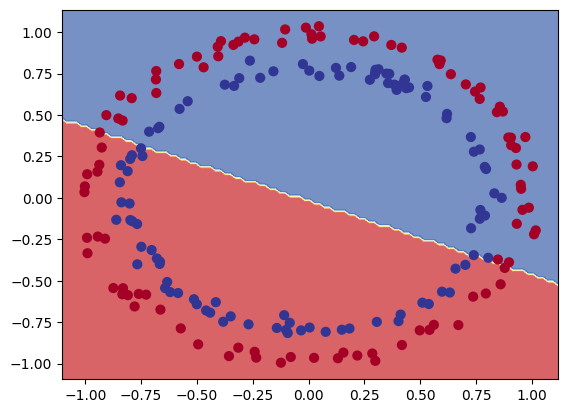

In [52]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
plot_decision_boundary(model=model_0, X=X_test, y=y_test)

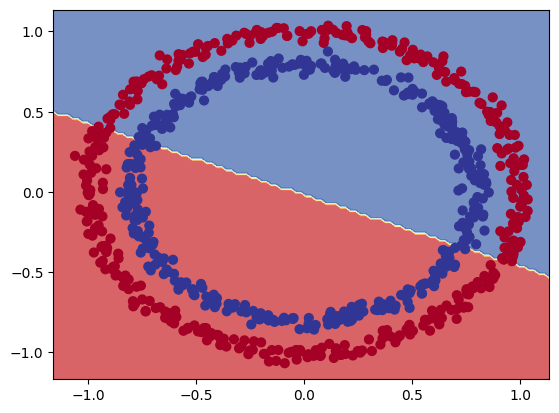

In [53]:
plot_decision_boundary(model=model_0, X=X_train, y=y_train)


In [59]:
# model_1=nn.Sequential(
#     nn.Linear(in_features=2,out_features=10),
#     nn.ReLU(),
#     nn.Linear(in_features=10,out_features=10),
#     nn.ReLU(),
#     nn.Linear(in_features=10,out_features=1),
#
# )
# we can use either of this models to add some nonlinearity in the model

class CircleModelV0(nn.Module):
   def __init__(self):
         super().__init__()
         self.layer_1=nn.Linear(in_features=2,out_features=10)
         self.layer_2=nn.Linear(in_features=10,out_features=10)
         self.layer_3=nn.Linear(in_features=10,out_features=1)
         self.ReLU=nn.ReLU()

   def forward(self,x):
         return self.layer_3(self.ReLU(self.layer_2(self.ReLU(self.layer_1(x)))))

model_1=CircleModelV0().to(device)
model_1
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model_1.parameters(),lr=0.1)
epochs=800
for epoch in range(epochs):
    model_1.train()
    y_logits=model_1(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    train_loss=loss_fn(y_logits,y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

    model_1.eval()

    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)


    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70202, Accuracy: 50.00% | Test loss: 0.70305, Test acc: 50.00%
Epoch: 10 | Loss: 0.54866, Accuracy: 86.50% | Test loss: 0.53011, Test acc: 85.00%
Epoch: 20 | Loss: 0.17789, Accuracy: 98.25% | Test loss: 0.18884, Test acc: 96.00%
Epoch: 30 | Loss: 0.03592, Accuracy: 99.88% | Test loss: 0.05841, Test acc: 99.00%
Epoch: 40 | Loss: 0.01130, Accuracy: 99.88% | Test loss: 0.02626, Test acc: 99.00%
Epoch: 50 | Loss: 0.00499, Accuracy: 100.00% | Test loss: 0.01431, Test acc: 99.50%
Epoch: 60 | Loss: 0.00334, Accuracy: 100.00% | Test loss: 0.01297, Test acc: 100.00%
Epoch: 70 | Loss: 0.00246, Accuracy: 100.00% | Test loss: 0.01101, Test acc: 100.00%
Epoch: 80 | Loss: 0.00193, Accuracy: 100.00% | Test loss: 0.00858, Test acc: 100.00%
Epoch: 90 | Loss: 0.00163, Accuracy: 100.00% | Test loss: 0.00762, Test acc: 100.00%
Epoch: 100 | Loss: 0.00142, Accuracy: 100.00% | Test loss: 0.00735, Test acc: 100.00%
Epoch: 110 | Loss: 0.00126, Accuracy: 100.00% | Test loss: 0.00666, Test acc

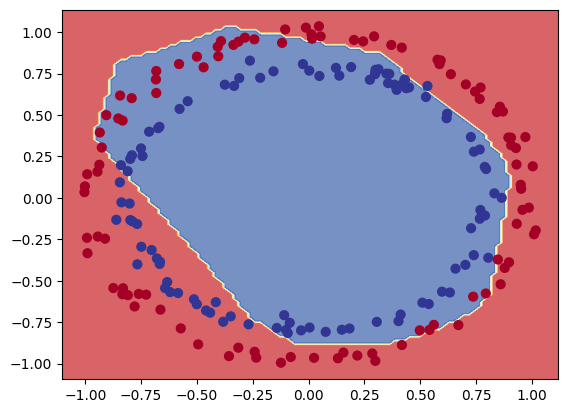

In [55]:
plot_decision_boundary(model=model_1, X=X_test, y=y_test)


In [56]:
model_1

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (ReLU): ReLU()
)